In [1]:
!pip install torch==0.4.1
!pip install torchvision==0.2.1
!pip install numpy==1.14.6
!pip install matplotlib==2.1.2
!pip install pillow==5.0.0
!pip install opencv-python==3.4.3.18
!pip install logzero

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
%matplotlib inline
from matplotlib import pyplot as plt
import logzero
logger = logzero.setup_logger(
              name='train_logger',
              level=10,
              formatter=None)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
image,label = train_dataset[0]
print(image.size())
print(label)

torch.Size([1, 28, 28])
tensor(9)


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=64,shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=64,shuffle=False,num_workers=2)

In [0]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN,self).__init__()
        self.features = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3
                  ,stride=3,padding=1), #グレースケール画像なので1から
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128,64,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64,32,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier = nn.Linear(32,num_classes)
        
    def forward(self,x):
        x = self.features(x) #nn.Sequential()の恩恵でめちゃくちゃ綺麗
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum=0.9,weight_decay=5e-4)

In [7]:
nepochs = 20 #エポック数

#最後に学習曲線を出すため
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

logger.info('Training Start')
for epoch in range(nepochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
        
    net.train() #学習モード
    for i, (images,labels) in enumerate(train_loader): #ミニバッチで分割
        #MLPの時と違い変換する必要なし
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = net(images) #順伝播の計算
        loss = criterion(outputs,labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward() #損失関数の逆伝播
        optimizer.step() #パラメータ更新
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
        
    net.eval() #評価モード
    with torch.no_grad(): #評価する時に無駄な計算をしない
        for images,labels in test_loader: 
            #MLPの時と違い変換する必要なし
            
            images = images.to(device)
            labels  = labels.to(device)
            outputs = net(images)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
            
        print(f'Epoch[{epoch+1}/{nepochs}], Loss: {round(avg_train_loss,4)},val_loss:{round(avg_val_loss,4)},val_acc:{round(avg_val_acc,4)}')
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

[I 190115 08:20:47 <ipython-input-7-7b9bdff1b062>:9] Training Start


Epoch[1/20], Loss: 0.0291,val_loss:0.0123,val_acc:0.6996
Epoch[2/20], Loss: 0.0095,val_loss:0.0056,val_acc:0.8056
Epoch[3/20], Loss: 0.007,val_loss:0.0069,val_acc:0.8395
Epoch[4/20], Loss: 0.0061,val_loss:0.0054,val_acc:0.8607
Epoch[5/20], Loss: 0.0056,val_loss:0.0035,val_acc:0.8563
Epoch[6/20], Loss: 0.0053,val_loss:0.0067,val_acc:0.8642
Epoch[7/20], Loss: 0.0051,val_loss:0.0083,val_acc:0.8622
Epoch[8/20], Loss: 0.0049,val_loss:0.0043,val_acc:0.8749
Epoch[9/20], Loss: 0.0046,val_loss:0.0053,val_acc:0.8703
Epoch[10/20], Loss: 0.0045,val_loss:0.0043,val_acc:0.875
Epoch[11/20], Loss: 0.0044,val_loss:0.0062,val_acc:0.877
Epoch[12/20], Loss: 0.0043,val_loss:0.0025,val_acc:0.88
Epoch[13/20], Loss: 0.0042,val_loss:0.0035,val_acc:0.882
Epoch[14/20], Loss: 0.0041,val_loss:0.0026,val_acc:0.86
Epoch[15/20], Loss: 0.004,val_loss:0.0034,val_acc:0.8822
Epoch[16/20], Loss: 0.0039,val_loss:0.0021,val_acc:0.8832
Epoch[17/20], Loss: 0.0038,val_loss:0.002,val_acc:0.8806
Epoch[18/20], Loss: 0.0038,val_lo

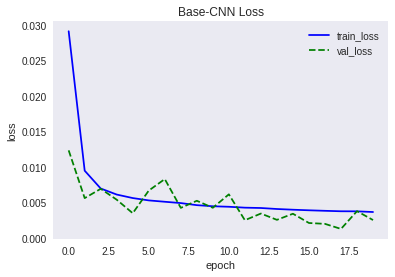

In [8]:
plt.figure()
plt.plot(range(nepochs),train_loss_list,color='blue',linestyle='-',label='train_loss')
plt.plot(range(nepochs),val_loss_list,color='green',linestyle='--',label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Base-CNN Loss')
plt.grid()

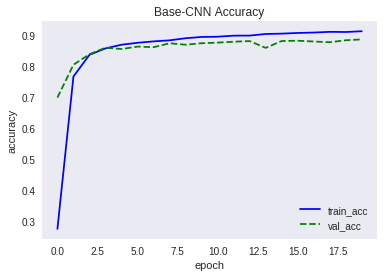

In [9]:
 #過学習してる?
plt.figure()
plt.plot(range(nepochs),train_acc_list,color='blue',linestyle='-',label='train_acc')
plt.plot(range(nepochs),val_acc_list,color='green',linestyle='--',label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Base-CNN Accuracy')
plt.grid()

In [10]:
print(f'Final Accuracy:{round(val_acc_list[-1]*100,2)}%')

Final Accuracy:88.74%
